# Assignmnent 1: Expressive Timing in Performance
In this assignment we explore the distortion of the metrical grid in human performance. Your task is to find a interesting mapping from symbolic time to real time.

Dataset: https://github.com/fosfrancesco/asap-dataset.

- For each piece, the dataset contains two versions of MIDI files:
  - unperformed MIDI corresponds to strict timing as shown in the score.
  - performed MIDI corresponds to MIDI recording from human musicians performing the piece. In these files you will find the timing of the notes does not corresponds strictly to the symbolic metrical grid (i.e. the metrical grid is distorted).
- The dataset contains pieces from different styles, you can decide which subcollection to use.
- The dataset does not contain information about loudness/dynamics in the MIDI files (in a MIDI file this is called the "velocity" attribute). For this assignment, any attempts to model velocity will be considered a plus and you can do it freely according to your musical intuition.


In [ ]:
# Install dependencies
!pip install music21
!apt install musescore3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libpoppler-qt5-1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5help5 libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-general-soundfont-small musescore3-common qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts 

In [ ]:
# Import libraries
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import music21
from music21 import midi, converter, meter, corpus, instrument, note, chord, pitch

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the path if necessary:
root_dir = '/content/drive/Shareddrives/dh401_digital_musicology/'
os.chdir(root_dir)
!ls

11			 assignment1.ipynb	   assignment1_taskB2.ipynb  midi_score.mid
asap-dataset-master	 assignment1_taskA.ipynb   ct_notebook.ipynb	     Mozart_Piano_Sonatas
asap-dataset-master.zip  assignment1_taskB1.ipynb  Fantasie_475		     Shi05M.mid


## Task A (The timing function)

- Implement a function timing that maps symbolic time to performance attributes (tempo,velocity), so that one can use it to transform the "unperformed" MIDI to the "performed" MIDI.
  - Plot this function as a tempo curve that happens in time.
  -         (Optional) Plot this function as a velocity curve that happens in time.

## Task B (Empirical findings)
- Choose one subcorpus (for example Bach Preludes) and do the following analyses:
  - What is the distribution of note onsets on metrical locations? Answer this question separately for different time signatures. At least do 4/4 and 3/4 time signatures. Illustrate your finding with figures.
  - Where in the metrical grid are expressive timing likely to happen? Support it with quantitative evidence. Illustrate your finding with figures.


- Think about another empirical question that you can verify from this data, and present your findings.
  - (Easy example) which style has the most variability in timing.
  - (Difficult example) How well can your model generalize across different styles?


# 1. Timing Variability in Mozart's Works based on Piano Sonatas vs. Fantasie.

## Help Functions

In [ ]:
# Combine parsing, simplifying the sample score and extracting the rhythm
def helpers_parse_simplify_and_extract_rhythm(sample):

    sample_score_tmp = converter.parse(sample)

    # remove chord charts, metronome mark, dynamics
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.harmony.ChordSymbol):
                    measure.remove(event)
                if isinstance(event, music21.tempo.MetronomeMark):
                    measure.remove(event)
                if isinstance(event, music21.dynamics.Dynamic):
                    measure.remove(event)
                if isinstance(event, music21.key.KeySignature):
                    measure.remove(event)

    # combine voice tracks intra-staff (done by extracted staffs and recombining)
    chordified_treble = sample_score_tmp.parts[0].chordify()
    sample_score = music21.stream.Score()
    sample_score.insert(0, chordified_treble)

    # cast all single-note chord objects (created by chordify) as note objects so students see more typical music21 score object structure
    staff_count = 0
    for part in sample_score.parts:
        staff_count += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.chord.Chord): # and len(event.notes) == 1:
                    note_version = music21.note.Note()
                    if staff_count == 1:
                        note_version.pitch = music21.pitch.Pitch('C4')
                    elif staff_count == 2:
                        note_version.pitch = music21.pitch.Pitch('C3')
                    note_version.duration = event.duration
                    start_found = 0
                    continue_found = 0
                    none_found = 0
                    all_ties_stop = 1
                    for nte in event.notes:
                        try:
                            curr_tie_obj = nte.tie.type
                        except:
                            curr_tie_obj = None
                        if (curr_tie_obj == 'start'):
                            start_found = 1
                        if (curr_tie_obj == 'continue'):
                            continue_found = 1
                        if (curr_tie_obj is None):
                            none_found = 1
                        if (curr_tie_obj != 'stop'):
                            all_ties_stop = 0
                    if start_found == 1:
                        note_version.tie = music21.tie.Tie('start')
                    elif none_found == 1:
                        note_version.tie = None
                    elif all_ties_stop == 1:
                        note_version.tie = music21.tie.Tie('stop')
                    elif continue_found == 1:
                        note_version.tie = music21.tie.Tie('continue')
                    note_version.offset = event.offset
                    note_version.articulations = event.articulations
                    note_version.expressions = event.expressions
                    measure.replace(event, note_version)

    # fix instances where tie start leads to tie None (should be no tie but previous loop isn't built to observe two consecutive elements)
    # the ties are a pain >:"{
    for part in sample_score.parts:
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)-1):
                curr_event = measure[i]
                next_event = measure[i+1]
                if isinstance(curr_event, music21.note.Note) and isinstance(next_event, music21.note.Note):
                    try:
                        curr_tie = curr_event.tie.type
                    except:
                        curr_tie = None
                    try:
                        next_tie = next_event.tie.type
                    except:
                        next_tie = None
                    if (curr_tie == 'start' or curr_tie == 'continue') and (next_tie == 'start' or next_tie is None):
                        measure[i].tie = music21.tie.Tie('stop')
                if isinstance(curr_event, music21.note.Rest):
                    measure[i].tie = None

    # combine tied notes intra-staff
    for part in sample_score.parts:
        active_tie = 0
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)):
                if isinstance(measure[i], music21.note.Note):
                    if measure[i].tie is not None:
                        if measure[i].tie.type == "start":
                            active_tie = 1
                        elif measure[i].tie.type == "stop" and active_tie == 1:
                            active_tie = 0
                        elif measure[i].tie.type == "stop" and active_tie == 0:
                            measure[i].tie = None

    treble = sample_score.parts[0]
    for measure in treble.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    sample_score = music21.stream.Score()
    sample_score.insert(0, treble)

    # deciding against repeat expands for now due to issues with measure number

    # return sample_score

    #then combing to extract rhythom data

    # def extract_rhythm_data(sample_score):
    """
    Extract rhythm data from a music21 Score object.

    Parameters:
    - sample_score (music21.stream.Score): The music21 Score object to extract rhythm data from.

    Returns:
    - rhythm_data_df (pandas.DataFrame): A DataFrame containing extracted rhythm data.
    """

    # Initialize a list to store rhythm data
    rhythm_data_list = []

    # Iterate over parts in the score
    for clef in sample_score.parts:
        global_onset = 0  # Initialize global onset
        clef_name = clef.elements[0].clef.name  # Get clef name
        # Iterate over measures in the part
        for measure in clef.getElementsByClass('Measure'):
            # Iterate over events in the measure
            for event in measure.recurse():
                label = ""  # Initialize label
                # Determine event type (note or rest)
                if isinstance(event, music21.note.Note):
                    label = "sounded"
                if isinstance(event, music21.note.Rest):
                    label = "unsounded"
                # Determine tie information if applicable
                try:
                    tie_info = "tie_" + event.tie.type
                except:
                    tie_info = ""
                # Add data to rhythm_data_list
                if label != "":
                    global_onset = ((measure.measureNumber-1) * 4) + event.offset
                    rhythm_data_list.append((clef_name, measure.measureNumber, label, event.offset, global_onset, event.duration.quarterLength, tie_info))

    # Convert rhythm_data_list to a DataFrame
    rhythm_data_df = pd.DataFrame(rhythm_data_list, columns=['staff', 'measure_number', 'event_type', 'onset_in_measure', 'onset_in_score', 'duration', 'tie_info'])

    return rhythm_data_df

In [ ]:
def load_mid_files(root_dir):
    """
    Load MIDI files from the root directory. If the root directory contains subfolders,
    it loads MIDI files from those subfolders. If it contains MIDI files directly,
    it loads them without entering further subdirectories.

    Parameters:
    - root_dir (str): Path to the root directory containing MIDI files or subfolders with MIDI files.

    Returns:
    - midi_files (dict): A dictionary containing loaded MIDI files, grouped by subfolder name,
                         or directly under the root if no subfolders are present.
    """

    midi_files = {}

    # Check if the root directory contains any subdirectories
    contains_subfolders = any(os.path.isdir(os.path.join(root_dir, item)) for item in os.listdir(root_dir))

    if contains_subfolders:
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                midi_files[subfolder] = {}
                for filename in os.listdir(subfolder_path):
                    if filename.endswith('.mid'):
                        file_path = os.path.join(subfolder_path, filename)
                        midi_files[subfolder][filename] = file_path
    else:
        # The root directory does not contain subfolders, load MIDI files directly
        midi_files[root_dir] = {}
        for filename in os.listdir(root_dir):
            if filename.endswith('.mid'):
                file_path = os.path.join(root_dir, filename)
                midi_files[root_dir][filename] = file_path

    return midi_files

In [ ]:
def calculate_and_print_std_for_midi_directories(root_dir, parent_path=""):
    """
    Recursively calculate and print the standard deviation for timing differences
    Assumes the lowest level will contain MIDI files directly and calculates the standard deviation there.

    Parameters:
    - root_dir (str): Path to the current directory being processed.
    - parent_path (str): Accumulated path for maintaining hierarchy, excluding the base prefix.
    """
    base_prefix = "/content/drive/Shareddrives/dh401_digital_musicology/"
    midi_files = load_mid_files(root_dir)

    # Adjust the parent_path for the first call
    if not parent_path:
        parent_path = root_dir.replace(base_prefix, "")
    else:
        # For subsequent calls, append the current directory to the parent_path
        parent_path = os.path.join(parent_path, os.path.basename(root_dir))

    for subfolder, files in midi_files.items():
        current_path = os.path.join(root_dir, subfolder)
        relative_path = os.path.join(parent_path, subfolder).replace(base_prefix, "")

        # Check for further subdirectories
        if any(os.path.isdir(os.path.join(current_path, item)) for item in os.listdir(current_path)):
            calculate_and_print_std_for_midi_directories(current_path, parent_path)
        else:
            # Leaf directory; calculate and print standard deviation
            try:
                unperformed_file_path = files.get('midi_score.mid')
                if unperformed_file_path:
                    unperformed_rhythm_df = helpers_parse_simplify_and_extract_rhythm(unperformed_file_path)
                    unperformed_note_onset = unperformed_rhythm_df['onset_in_score']
                    std_devs = []

                    for file_name, file_path in files.items():
                        if file_name != 'midi_score.mid':
                            performed_rhythm_df = helpers_parse_simplify_and_extract_rhythm(file_path)
                            performed_note_onset = performed_rhythm_df['onset_in_score']
                            timing_differences = unperformed_note_onset - performed_note_onset
                            std_dev = timing_differences.std()
                            std_devs.append(std_dev)

                    if std_devs:
                        average_std = sum(std_devs) / len(std_devs)
                        print(f"Directory: {relative_path}, Average Std Dev: {average_std}")
                else:
                    print(f"'midi_score.mid' not found in {relative_path}")
            except KeyError:
                print(f"Error processing {current_path}")

In [ ]:
calculate_and_print_std_for_midi_directories(root_dir + "Fantasie_475")
calculate_and_print_std_for_midi_directories(root_dir + "Mozart_Piano_Sonatas")

Directory: Fantasie_475, Average Std Dev: 17.050650662187756
Directory: Mozart_Piano_Sonatas/11-3, Average Std Dev: 169.22873322341403
Directory: Mozart_Piano_Sonatas/8-1, Average Std Dev: 49.09490062733329
Directory: Mozart_Piano_Sonatas/12-1, Average Std Dev: 150.62154462174183
Directory: Mozart_Piano_Sonatas/12-2, Average Std Dev: 96.66934807566889
Directory: Mozart_Piano_Sonatas/12-3, Average Std Dev: 128.1805121873664


In [ ]:
directories = [
    "Fantasie_475",
    "Mozart_Piano_Sonatas/11-3",
    "Mozart_Piano_Sonatas/8-1",
    "Mozart_Piano_Sonatas/12-1",
    "Mozart_Piano_Sonatas/12-2",
    "Mozart_Piano_Sonatas/12-3"
]
average_std_devs = [
    17.050650662187756,
    169.22873322341403,
    49.09490062733329,
    150.62154462174183,
    96.66934807566889,
    128.1805121873664
]

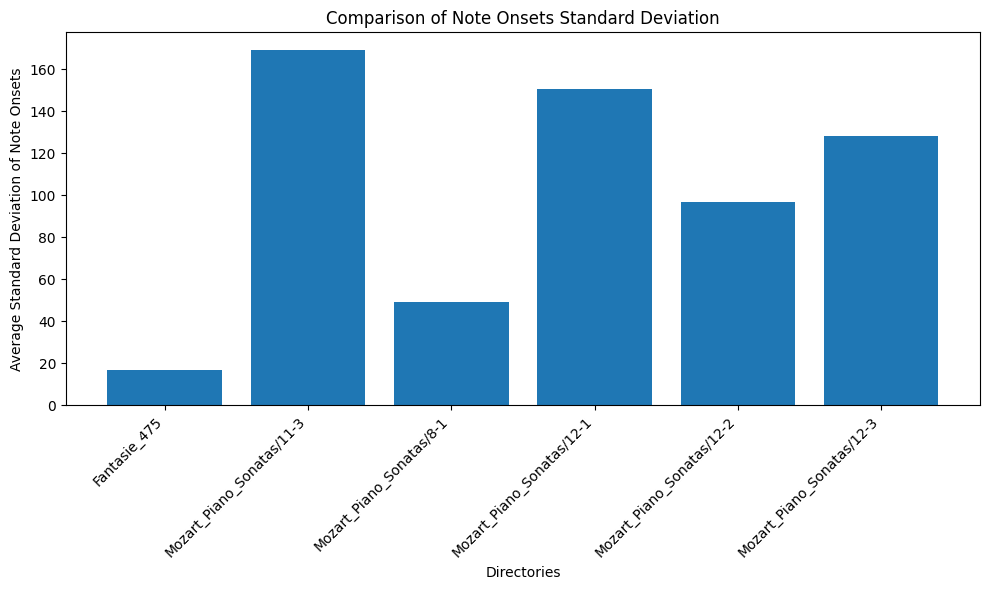

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(directories, average_std_devs)
plt.xlabel('Directories')
plt.ylabel('Average Standard Deviation of Note Onsets')
plt.title('Comparison of Note Onsets Standard Deviation')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

# 2. Which style has the most variability in timing?

In [ ]:
import zipfile

zip_file_path = 'asap-dataset-master.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

for item in os.listdir('.'):
    print(item)

Shi05M.mid
midi_score.mid
assignment1_taskA.ipynb
Mozart_Piano_Sonatas
assignment1.ipynb
Fantasie_475
ct_notebook.ipynb
assignment1_taskB1.ipynb
assignment1_taskB2.ipynb
asap-dataset-master.zip
asap-dataset-master


In [ ]:
calculate_and_print_std_for_midi_directories(root_dir + "asap-dataset-master")

Directory: asap-dataset-master/Bach/Fugue/bwv_846, Average Std Dev: 10.4585381600459
Directory: asap-dataset-master/Bach/Fugue/bwv_848, Average Std Dev: 6.7082656664702
Directory: asap-dataset-master/Bach/Fugue/bwv_854, Average Std Dev: 3.7137534171108997
Directory: asap-dataset-master/Bach/Fugue/bwv_856, Average Std Dev: 49.38877930094931
Directory: asap-dataset-master/Bach/Fugue/bwv_857, Average Std Dev: 6.85917888384109
Directory: asap-dataset-master/Bach/Fugue/bwv_858, Average Std Dev: 4.119323881960239
Directory: asap-dataset-master/Bach/Fugue/bwv_860, Average Std Dev: 27.017638635502333
Directory: asap-dataset-master/Bach/Fugue/bwv_862, Average Std Dev: 6.01722277949788
Directory: asap-dataset-master/Bach/Fugue/bwv_863, Average Std Dev: 13.119649202507384
Directory: asap-dataset-master/Bach/Fugue/bwv_864, Average Std Dev: 5.539352750845036
Directory: asap-dataset-master/Bach/Fugue/bwv_865, Average Std Dev: 11.274950726840979
Directory: asap-dataset-master/Bach/Fugue/bwv_866, Aver

In [ ]:
import os

def calculate_stats_for_composers(root_dir):
    """
    Calculate and return the average standard deviation of timing differences for each composer's works in the dataset,
    along with the count of works for each composer.
    """
    composers_stats = {}

    for composer in os.listdir(root_dir):
        composer_path = os.path.join(root_dir, composer)
        if not os.path.isdir(composer_path):
            continue

        composer_works_std = []
        work_count = 0
        for subdir, dirs, files in os.walk(composer_path):
            if not any(os.path.isdir(os.path.join(subdir, d)) for d in dirs):  # It's a leaf directory
                work_std = calculate_std_for_work(subdir, os.listdir(subdir))
                if work_std is not None:
                    composer_works_std.append(work_std)  # Add the avg std dev for this work
                    work_count += 1  # Add the work count

        if composer_works_std:
            composers_stats[composer] = {'std_devs': composer_works_std, 'work_count': work_count}

    return composers_stats

def calculate_std_for_work(work_dir, files):
    """
    Calculate the average standard deviation of timing differences for all performaned versions
    of a work compared to its unperformed version.
    """
    file_paths = {file: os.path.join(work_dir, file) for file in files if file.endswith('.mid') or file.endswith('.midi')}
    unperformed_file_path = file_paths.get('midi_score.mid')
    std_devs = []

    if unperformed_file_path:
        unperformed_rhythm_df = helpers_parse_simplify_and_extract_rhythm(unperformed_file_path)
        unperformed_note_onset = unperformed_rhythm_df['onset_in_score']

        for file_name, file_path in file_paths.items():
            if file_name != 'midi_score.mid':
                performed_rhythm_df = helpers_parse_simplify_and_extract_rhythm(file_path)
                performed_note_onset = performed_rhythm_df['onset_in_score']
                timing_differences = unperformed_note_onset - performed_note_onset
                std_dev = timing_differences.std()
                std_devs.append(std_dev)

    # Return the average standard deviation for this work
    return sum(std_devs) / len(std_devs) if std_devs else None

In [ ]:
calculate_stats_for_composers(root_dir + "asap-dataset-master")

{'Bach': {'std_devs': [10.4585381600459,
   6.7082656664702,
   3.7137534171108997,
   49.38877930094931,
   6.85917888384109,
   4.119323881960239,
   27.017638635502333,
   6.01722277949788,
   13.119649202507384,
   5.539352750845036,
   11.274950726840979,
   17.023239987326285,
   39.510875425278186,
   2.383549761795996,
   56.305660781148106,
   30.62159496757701,
   4.547885697309522,
   6.071257838876815,
   40.16605981597442,
   80.71524111977956,
   15.391300992779144,
   55.76125216800185,
   35.716568252541784,
   35.35693902669457,
   2.153803823111939,
   3.7640132748339425,
   42.19652865460226,
   28.2954118144969,
   78.71020575266334,
   48.00522034634806,
   16.30538084673369,
   83.4499490796902,
   5.4918479158544145,
   8.298206580767735,
   14.698071882043536,
   7.5094817314065105,
   2.3829285297129332,
   20.993968009897152,
   3.6285297418382316,
   3.6278613673583573,
   7.480069754440961,
   3.2604926451019356,
   26.410422432488417,
   1.1421358113343618,

In [ ]:
composer_stats = calculate_stats_for_composers(root_dir + "asap-dataset-master")

In [ ]:
data = []
for composer, stats in composer_stats.items():
    for std_dev in stats['std_devs']:
        data.append((composer, std_dev))

df = pd.DataFrame(data, columns=['Composer', 'Standard Deviation'])

print(df.head())

  Composer  Standard Deviation
0     Bach           10.458538
1     Bach            6.708266
2     Bach            3.713753
3     Bach           49.388779
4     Bach            6.859179


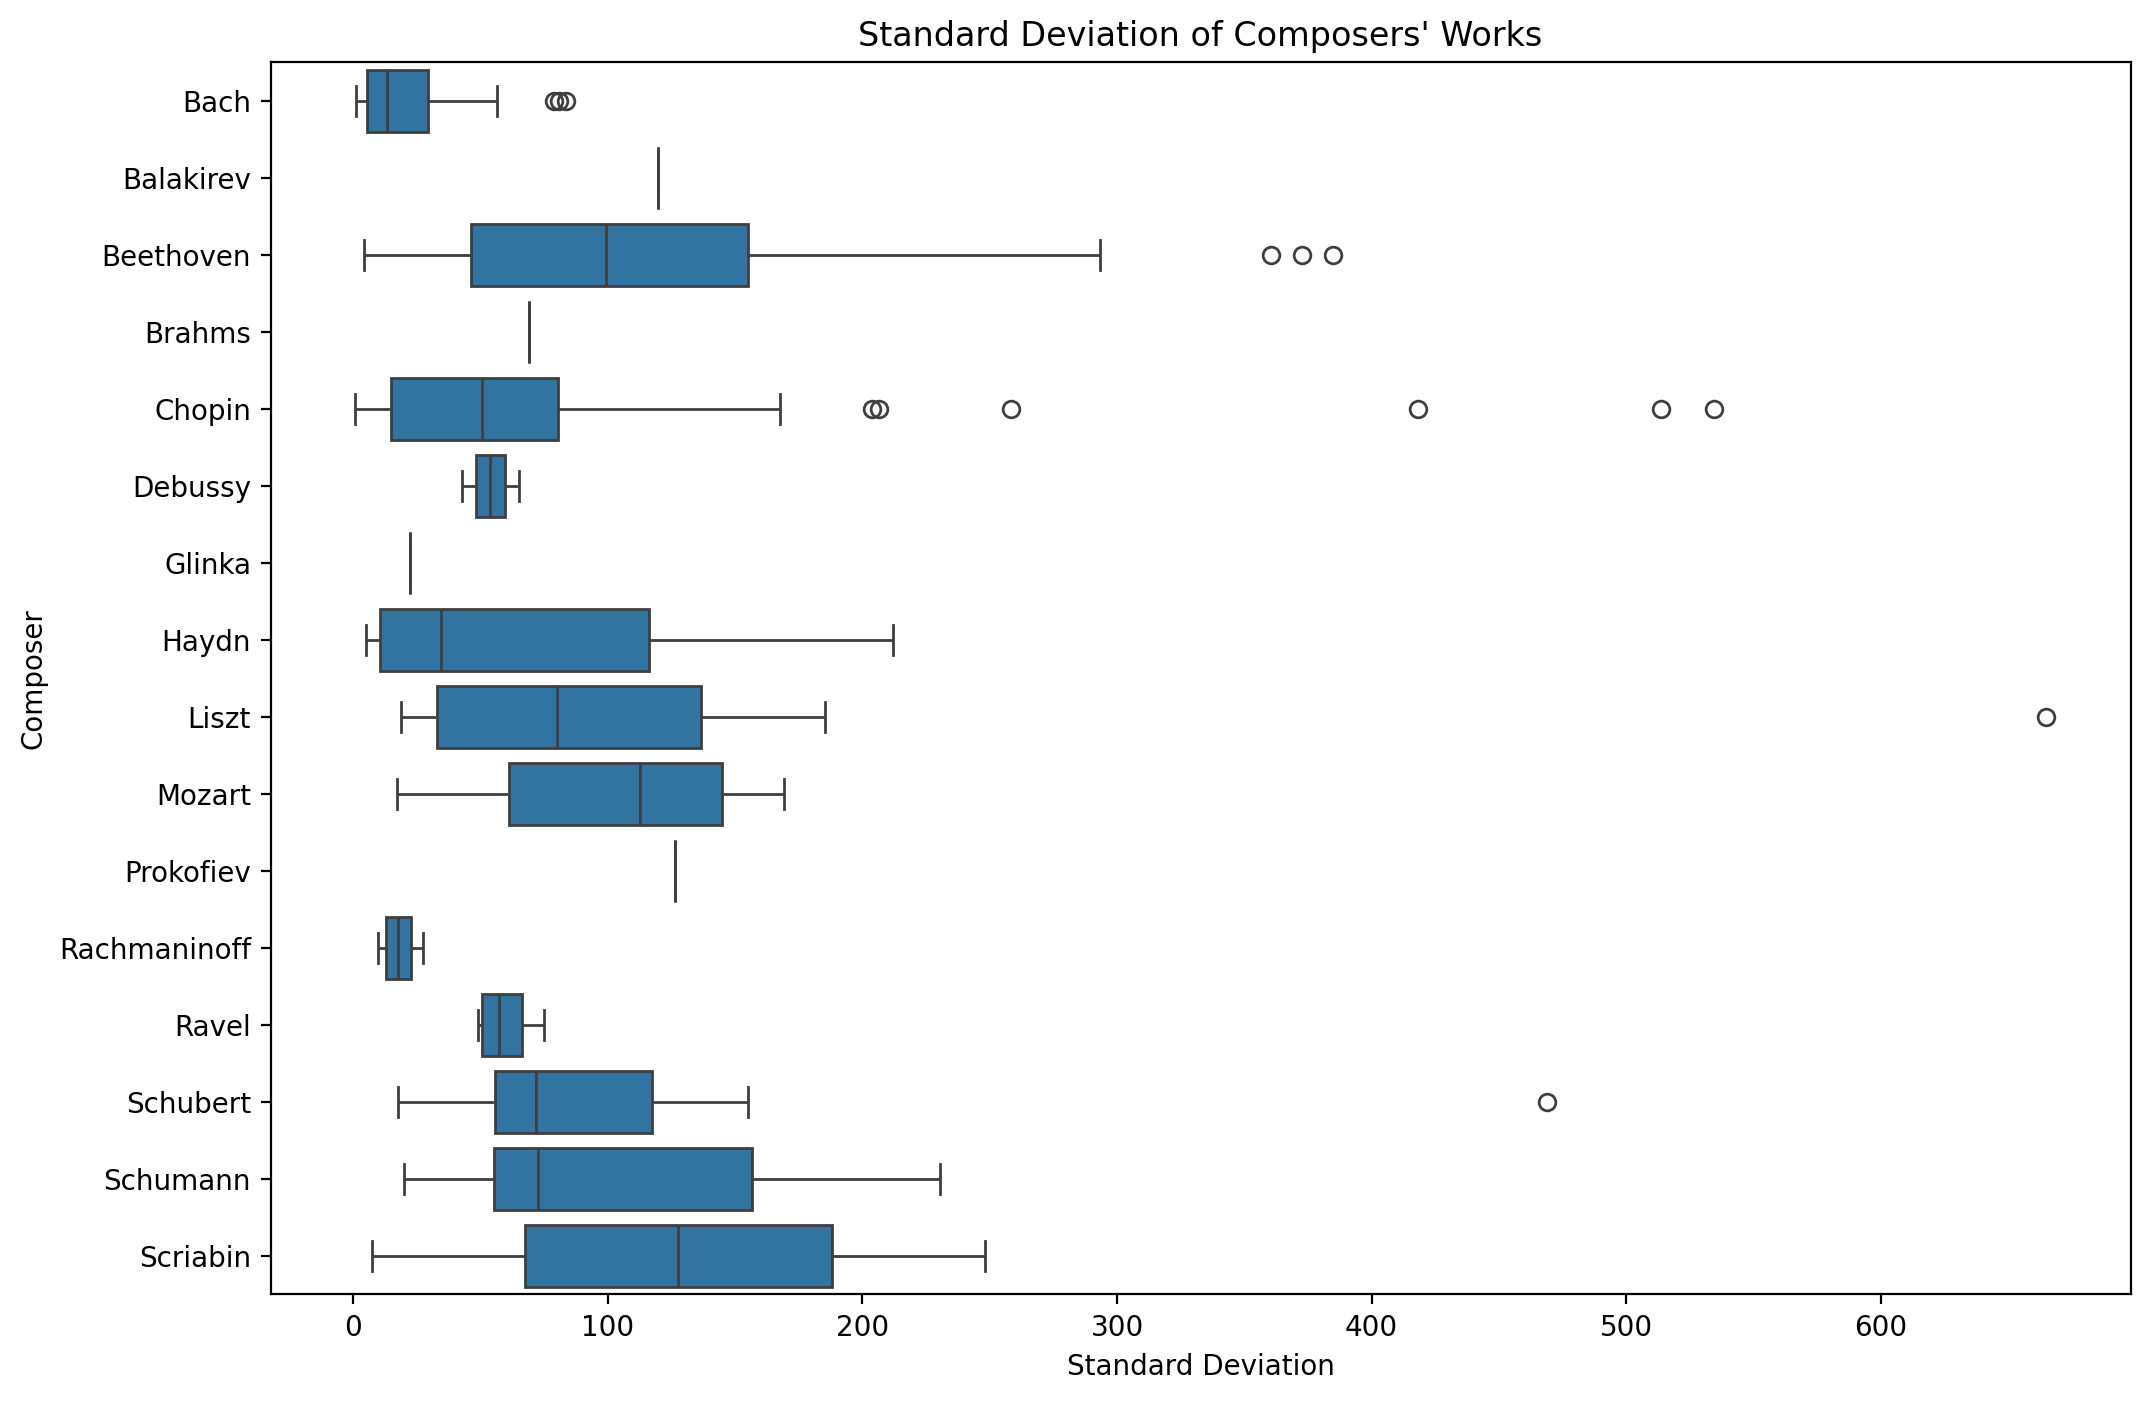

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Standard Deviation', y='Composer', data=df)
plt.title('Standard Deviation of Composers\' Works')
plt.show()